In [1]:
! pip install Unidecode
! pip install arabic-reshaper
! pip install python-bidi
! pip install -U kaleido

In [4]:
import requests
import json
import time
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from unidecode import unidecode
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plt.style.use("ggplot")

# Data Scraping

<blockquote>

The code for data scraping from divar is available at divar_scraper.ipynb.

At first I investigated the possibility of crawling the website and extracting the data.
As seen in the picture below, after scrolling, divar client sends a request to the API.

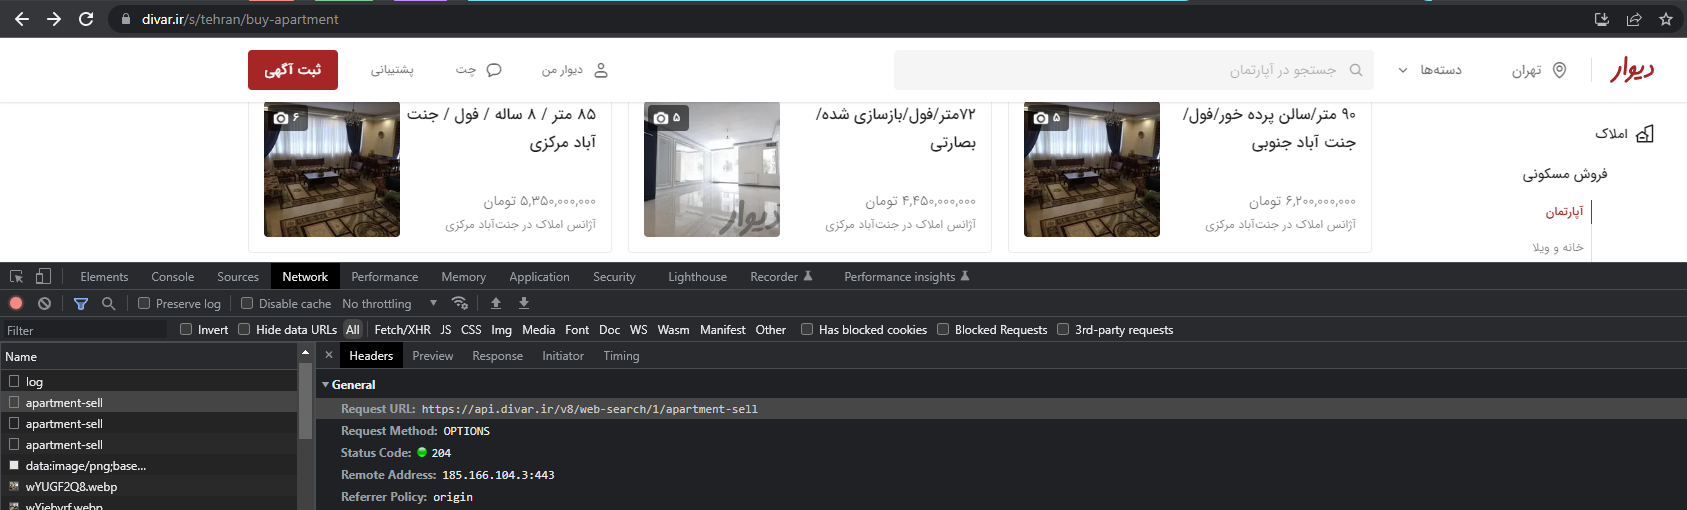

<blockquote>

Based on this API, I figured out I can access the data of the search pages by sending a POST request to https://api.divar.ir/v8/web-search/1/apartment-sell.

Also, the payload looks like below:
```json
{
    "json_schema":{
        "category":{"value":"apartment-sell"},
        "cities":["1"]
    },
    "last-post-date":1671722824386533
}
```
As I have selected apartment-sell category to analyze, the category is "apartment-sell".

Moreover, the city was Tehran which has the code of 1. The codes for all the cities are available at https://api.divar.ir/v8/places/cities. I chose to use the below cities for gathering the data.
```json
cities = {
    1: "Tehran",
    2: "Karaj",
    3: "Mashhad",
    4: "Isfahan",
    5: "Tabriz",
    6: "Shiraz",
    7: "Ahvaz",
    8: "Qom",
}
```

Finally, "last-post-date" indicates the epoch time of the last post shown to the user in the page. It is used for when the user scrolls to see new posts with older last-post_date than the last post they saw. I used this mechanism in my scraper to get new posts from the api.

For compeleteness, the code of divar-scraper is available below as well. (The API cannot be accessed from Google Colab. Please run this part from a local machine.

In [5]:
import requests
import json
import time
import pandas as pd
from tqdm.auto import tqdm

place2_map = {
    1: "Tehran",
    2: "Karaj",
    3: "Mashhad",
    4: "Isfahan",
    5: "Tabriz",
    6: "Shiraz",
    7: "Ahvaz",
    8: "Qom",
}

def request_api(last_post_date=0):
    url = 'https://api.divar.ir/v8/web-search/1/apartment-sell'
    my_obj = {"json_schema":{"category":{"value":"apartment-sell"}, "cities":[str(i) for i in place2_map.keys()]}, "last-post-date":last_post_date}
    response = requests.post(url, json = my_obj)
    response_json = json.loads(response.text)
    return response_json

def flatten_dict(dd, separator='.', prefix=''):
    return {
        prefix + separator + k if prefix else k : v
        for kk, vv in dd.items()
        for k, v in flatten_dict(vv, separator, kk).items()
    } if isinstance(dd, dict) else { prefix : dd }

def retrieve_raw_dataset(iterations=60) -> pd.DataFrame:
    raw_dataset = []
    last_post_date=0
    for iteration in tqdm(range(iterations), desc="Iterations"):
        got_response = False
        while not got_response:
            try:
                response_json = request_api(last_post_date)
                for post_row in response_json["web_widgets"]['post_list']:
                    assert post_row['widget_type'] == "POST_ROW"
                    data = flatten_dict(post_row)
                    data["raw_response"] = response_json
                    raw_dataset.append(data)
                last_post_date = response_json["last_post_date"]  # Next Scroll
                time.sleep(1)
                got_response = True
            except Exception as e:
                print("API Call Failed!")
    return pd.DataFrame(raw_dataset)

### UNCOMMENT BELOW FOR TESTING
### THE RETRIEVED DATA IS AVAILABLE AT https://github.com/mohsenfayyaz/data-analytics-course-ut/blob/main/Project_EDA/divar_apartment_sell_24000.csv
# df = retrieve_raw_dataset(iterations=2)
# df.to_pickle("divar_data.pkl")
# df

<blockquote>

Each API call returns 24 posts. In the end, I called the API for 1000 times (30min) and acquired 24,000 unique posts available at: <br>
https://github.com/mohsenfayyaz/data-analytics-course-ut/blob/main/Project_EDA/divar_apartment_sell_24000.csv

# Data Cleaning

## Read Data

In [4]:
# Download the Scraped Data
! wget https://github.com/mohsenfayyaz/data-analytics-course-ut/raw/main/Project_EDA/divar_apartment_sell_24000.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
df = pd.read_csv("./divar_apartment_sell_24000.csv", low_memory=False, index_col=0)
df.head(2)

widget_type                               data.@type  \
0    POST_ROW  type.googleapis.com/widgets.PostRowData   
1    POST_ROW  type.googleapis.com/widgets.PostRowData   

                                      data.image_url  data.image_count  \
0                                                NaN                 0   
1  [{'src': 'https://s100.divarcdn.com/static/thu...                 6   

                                    data.title  data.has_chat  \
0                                  کلاهدوز صفر           True   
1  فروش ۱۰۰ متر آپارتمان ۲خواب // قیطریه جنوبی          False   

   data.top_description_text data.middle_description_text  \
0                        NaN          ۲,۸۵۰,۰۰۰,۰۰۰ تومان   
1                        NaN         ۱۳,۲۰۰,۰۰۰,۰۰۰ تومان   

  data.bottom_description_text data.red_text  ...  \
0          آژانس املاک در مشهد           NaN  ...   
1         آژانس املاک در تهران           NaN  ...   

  data.image_top_left_tag.icon.icon_color data.image_top_left_tag.text  \
0                                     NaN                          NaN   
1                           WHITE_PRIMARY                            ۶   

  data.image_top_left_tag.is_icon_left data.image_overlay_tag.text  \
0                                  NaN                         NaN   
1                                 True                         NaN   

  data.image_overlay_tag.image_url data.image_overlay_tag.image_color  \
0                              NaN                                NaN   
1                              NaN                                NaN   

  data.image_overlay_tag.icon.image_url_dark  \
0                                        NaN   
1                                        NaN   

  data.image_overlay_tag.icon.image_url_light  \
0                                         NaN   
1                                         NaN   

   data.image_overlay_tag.icon.icon_name  \
0                                    NaN   
1                                    NaN   

   data.image_overlay_tag.icon.icon_color  
0                                     NaN  
1                                     NaN  

[2 rows x 57 columns]

## Drop Columns

<blockquote>

What the API returns is targeted for the front-end to visualize. Also, there might be some data that are not necassary. In this part we find unique values of each column and delete the ones that add no information.

"data.title" and "data.action.payload.web_info.title" are the same for all the rows. So, we drop "data.action.payload.web_info.title". Also, some ui columns are not needed that we drop here.

In [7]:
for col_name in df.columns:
    uniques = df[col_name].unique()
    if len(uniques) == 1:
        print(f"Dropping column [{col_name}] which has only 1 value = {uniques}")
        df = df.drop(columns=col_name)

assert (df["data.title"] == df["data.action.payload.web_info.title"]).all() == True  # Title is duplicated
df = df.drop(
    columns=[
        "data.action.payload.web_info.title", 
        "action_log.server_side_info.info.index", 
        "data.image_top_left_tag.icon.image_url_light",
        "data.image_top_left_tag.icon.image_url_dark",
        "data.image_overlay_tag.icon.image_url_dark",
        "data.image_overlay_tag.icon.image_url_light",
        "data.image_url",
        "data.image_top_left_tag.icon.icon_color",
        "data.image_overlay_tag.image_url",
        "data.image_overlay_tag.image_color",
        "data.image_overlay_tag.icon.icon_name",
        "data.image_overlay_tag.icon.icon_color",
        "data.image_top_left_tag.text",
        "data.image_top_left_tag.text",
        "action_log.server_side_info.info.post_token",
        "data.image_top_left_tag.is_icon_left",
        "data.action.payload.token"
    ]
)

Dropping column [widget_type] which has only 1 value = ['POST_ROW']
Dropping column [data.@type] which has only 1 value = ['type.googleapis.com/widgets.PostRowData']
Dropping column [data.top_description_text] which has only 1 value = [nan]
Dropping column [data.action.type] which has only 1 value = ['VIEW_POST']
Dropping column [data.action.payload.@type] which has only 1 value = ['type.googleapis.com/widgets.ViewPostPayload']
Dropping column [data.action.payload.web_info.category_slug_persian] which has only 1 value = ['آپارتمان']
Dropping column [data.action.payload.vertical_info.@type] which has only 1 value = ['type.googleapis.com/base.VerticalInfo']
Dropping column [data.action.payload.vertical_info.vertical_type] which has only 1 value = [2]
Dropping column [data.action.fallback_link] which has only 1 value = [nan]
Dropping column [data.action.page_pop_link] which has only 1 value = [False]
Dropping column [data.checkable] which has only 1 value = [False]
Dropping column [data.l

## Clean Columns

<blockquote>

There are multiple columns curated for UI and here we need to extract the data we need from them. This information includes:

* **"data.middle_description_text":** <br>
includes the price in persian. such as <br>
۲,۹۰۰,۰۰۰,۰۰۰ تومان or توافقی <br>
which needs to be converted to an integer.

* **data.bottom_description_text:** <br>
includes the type of business of who posted. Such as 
آژانس املاک /
مشاور املاک /
شخصی
which needs to be extracted from texts such as مشاور املاک در تهران

* **data.red_text:** <br>
includes nan or فوری which should be converted to a column "promoted" and has a binary value.

* **action_log.server_side_info.info.extra_data.last_post_sort_date:** <br>
includes epoch time of approximate time of retreieving the data. It needs to be converted to datetime type.

* **data.image_top_left_tag.icon.icon_name**: <br>
includes nan 'CAMERA' 'VIDEOCAM' 'VR'. The column needs to be renamed to media.

* **data.image_overlay_tag.text**: <br>
includes nan 'صحت اطلاعات', which needs to be renamed to inspection and be binary column.

In [8]:
for col_name in df.columns:
    uniques = df[col_name].unique()
    print(f"{col_name.ljust(65)} > {uniques[:4]}...")
df.head(2)

data.image_count                                                  > [ 0  6 16  1]...
data.title                                                        > ['کلاهدوز صفر' 'فروش ۱۰۰ متر آپارتمان ۲خواب // قیطریه جنوبی'
 'آپارتمان ۱۱۰ متری کلید نخورده در خیابان مرتضوی'
 '116متر ، نوساز ، فول امکانات / شهرک صدف']...
data.has_chat                                                     > [ True False]...
data.middle_description_text                                      > ['۲,۸۵۰,۰۰۰,۰۰۰ تومان' '۱۳,۲۰۰,۰۰۰,۰۰۰ تومان' '۵,۱۳۰,۰۰۰,۰۰۰ تومان'
 '۲,۹۰۰,۰۰۰,۰۰۰ تومان']...
data.bottom_description_text                                      > ['آژانس املاک در مشهد' 'آژانس املاک در تهران' 'مشاور املاک در تهران'
 'لحظاتی پیش در کرج']...
data.red_text                                                     > [nan 'فوری ']...
data.action.payload.web_info.district_persian                     > ['کلاهدوز' 'قیطریه' 'هاشمی' 'شهر جدید اندیشه']...
data.action.payload.web_info.city_persian                         > ['مشهد' 

data.image_count                                   data.title  \
0                 0                                  کلاهدوز صفر   
1                 6  فروش ۱۰۰ متر آپارتمان ۲خواب // قیطریه جنوبی   

   data.has_chat data.middle_description_text data.bottom_description_text  \
0           True          ۲,۸۵۰,۰۰۰,۰۰۰ تومان          آژانس املاک در مشهد   
1          False         ۱۳,۲۰۰,۰۰۰,۰۰۰ تومان         آژانس املاک در تهران   

  data.red_text data.action.payload.web_info.district_persian  \
0           NaN                                       کلاهدوز   
1           NaN                                        قیطریه   

  data.action.payload.web_info.city_persian data.token  \
0                                      مشهد   wYaKSWxx   
1                                     تهران   wYVu85pC   

   action_log.server_side_info.info.extra_data.last_post_sort_date  \
0                                   1671715067723008                 
1                                   1671715067723008                 

  data.image_top_left_tag.icon.icon_name data.image_overlay_tag.text  
0                                    NaN                         NaN  
1                                 CAMERA                         NaN

In [9]:
def persian_to_price(x: str) -> int:
    if x == "توافقی":
        return np.nan
    x = unidecode(x)
    x = ''.join(c for c in x if c.isdigit())
    return int(x.strip())

def infer_business_type(x: str):
    if "آژانس" in x:
        return "agency"
    if "مشاور" in x:
        return "consultant"
    return "personal"

df["price_persian"] = df["data.middle_description_text"]
df["price_million"] = df["data.middle_description_text"].map(lambda x: persian_to_price(x)) / 1000000
df["business_type"] = df["data.bottom_description_text"].map(lambda x: infer_business_type(x))
df["promoted"] = df["data.red_text"] == 'فوری '
df["last_post_sort_date"] = pd.to_datetime(df["action_log.server_side_info.info.extra_data.last_post_sort_date"], unit='us')
df["media"] = df["data.image_top_left_tag.icon.icon_name"]
df["inspection"] = df["data.image_overlay_tag.text"] == 'صحت اطلاعات'

df = df.drop(columns=[
    "data.red_text", 
    "action_log.server_side_info.info.extra_data.last_post_sort_date", 
    "data.image_top_left_tag.icon.icon_name", 
    "data.image_overlay_tag.text", "data.middle_description_text",
    "data.bottom_description_text",
])
for col_name in df.columns:
    df = df.rename(columns={col_name: col_name.split(".")[-1]})
df = df.reindex(sorted(df.columns, reverse=True), axis=1)
df

token                                              title  promoted  \
0      wYaKSWxx                                        کلاهدوز صفر     False   
1      wYVu85pC        فروش ۱۰۰ متر آپارتمان ۲خواب // قیطریه جنوبی     False   
2      wYki1hsI     آپارتمان ۱۱۰ متری کلید نخورده در خیابان مرتضوی     False   
3      wYkilp7n            116متر ، نوساز ، فول امکانات / شهرک صدف     False   
4      wYkiFo1Z               قیطریه (کیکاووس) ۱۵۰ متر فول بازسازی     False   
...         ...                                                ...       ...   
23995  wYjqBo7O             141متر/تاپ لوکیشن/دو پارکینگ/تک بازدید     False   
23996  wYLiyCOY        آپارتمان 100متری صفرتاصد بازسازی نزدیک اصلی     False   
23997  wYjixctJ                            آپارتمان ۱۶۰ متر مهرشهر     False   
23998  wYjqhwMA                            آپارتمان ۱30 متری الهیه     False   
23999  wYjqhkBe  خرید واحدخانه خونه ۱۶۱متر سه خوابه حیاط بالکن ...     False   

              price_persian  price_million   media        last_post_sort_date  \
0       ۲,۸۵۰,۰۰۰,۰۰۰ تومان         2850.0     NaN 2022-12-22 13:17:47.723008   
1      ۱۳,۲۰۰,۰۰۰,۰۰۰ تومان        13200.0  CAMERA 2022-12-22 13:17:47.723008   
2       ۵,۱۳۰,۰۰۰,۰۰۰ تومان         5130.0  CAMERA 2022-12-22 13:17:47.723008   
3       ۲,۹۰۰,۰۰۰,۰۰۰ تومان         2900.0  CAMERA 2022-12-22 13:17:47.723008   
4      ۱۲,۶۰۰,۰۰۰,۰۰۰ تومان        12600.0     NaN 2022-12-22 13:17:47.723008   
...                     ...            ...     ...                        ...   
23995   ۴,۰۵۰,۰۰۰,۰۰۰ تومان         4050.0  CAMERA 2022-12-21 14:41:25.821502   
23996   ۱,۳۹۰,۰۰۰,۰۰۰ تومان         1390.0  CAMERA 2022-12-21 14:41:25.821502   
23997   ۲,۸۰۰,۰۰۰,۰۰۰ تومان         2800.0     NaN 2022-12-21 14:41:25.821502   
23998   ۳,۰۰۰,۰۰۰,۰۰۰ تومان         3000.0     NaN 2022-12-21 14:41:25.821502   
23999  ۱۲,۸۰۰,۰۰۰,۰۰۰ تومان        12800.0  CAMERA 2022-12-21 14:41:25.821502   

       inspection  image_count  has_chat district_persian city_persian  \
0           False            0      True          کلاهدوز         مشهد   
1           False            6     False           قیطریه        تهران   
2           False           16      True            هاشمی        تهران   
3           False            1     False  شهر جدید اندیشه          کرج   
4           False            0      True           قیطریه        تهران   
...           ...          ...       ...              ...          ...   
23995       False            1     False     محله هنرستان         مشهد   
23996       False            1     False            باهنر        اهواز   
23997       False            0     False        کیان آباد        اهواز   
23998       False            0      True            الهیه         مشهد   
23999       False            5     False        سازمان آب        تهران   

      business_type  
0            agency  
1            agency  
2        consultant  
3          personal  
4            agency  
...             ...  
23995        agency  
23996        agency  
23997      personal  
23998      personal  
23999    consultant  

[24000 rows x 13 columns]

# EDA

In [10]:
df

token                                              title  promoted  \
0      wYaKSWxx                                        کلاهدوز صفر     False   
1      wYVu85pC        فروش ۱۰۰ متر آپارتمان ۲خواب // قیطریه جنوبی     False   
2      wYki1hsI     آپارتمان ۱۱۰ متری کلید نخورده در خیابان مرتضوی     False   
3      wYkilp7n            116متر ، نوساز ، فول امکانات / شهرک صدف     False   
4      wYkiFo1Z               قیطریه (کیکاووس) ۱۵۰ متر فول بازسازی     False   
...         ...                                                ...       ...   
23995  wYjqBo7O             141متر/تاپ لوکیشن/دو پارکینگ/تک بازدید     False   
23996  wYLiyCOY        آپارتمان 100متری صفرتاصد بازسازی نزدیک اصلی     False   
23997  wYjixctJ                            آپارتمان ۱۶۰ متر مهرشهر     False   
23998  wYjqhwMA                            آپارتمان ۱30 متری الهیه     False   
23999  wYjqhkBe  خرید واحدخانه خونه ۱۶۱متر سه خوابه حیاط بالکن ...     False   

              price_persian  price_million   media        last_post_sort_date  \
0       ۲,۸۵۰,۰۰۰,۰۰۰ تومان         2850.0     NaN 2022-12-22 13:17:47.723008   
1      ۱۳,۲۰۰,۰۰۰,۰۰۰ تومان        13200.0  CAMERA 2022-12-22 13:17:47.723008   
2       ۵,۱۳۰,۰۰۰,۰۰۰ تومان         5130.0  CAMERA 2022-12-22 13:17:47.723008   
3       ۲,۹۰۰,۰۰۰,۰۰۰ تومان         2900.0  CAMERA 2022-12-22 13:17:47.723008   
4      ۱۲,۶۰۰,۰۰۰,۰۰۰ تومان        12600.0     NaN 2022-12-22 13:17:47.723008   
...                     ...            ...     ...                        ...   
23995   ۴,۰۵۰,۰۰۰,۰۰۰ تومان         4050.0  CAMERA 2022-12-21 14:41:25.821502   
23996   ۱,۳۹۰,۰۰۰,۰۰۰ تومان         1390.0  CAMERA 2022-12-21 14:41:25.821502   
23997   ۲,۸۰۰,۰۰۰,۰۰۰ تومان         2800.0     NaN 2022-12-21 14:41:25.821502   
23998   ۳,۰۰۰,۰۰۰,۰۰۰ تومان         3000.0     NaN 2022-12-21 14:41:25.821502   
23999  ۱۲,۸۰۰,۰۰۰,۰۰۰ تومان        12800.0  CAMERA 2022-12-21 14:41:25.821502   

       inspection  image_count  has_chat district_persian city_persian  \
0           False            0      True          کلاهدوز         مشهد   
1           False            6     False           قیطریه        تهران   
2           False           16      True            هاشمی        تهران   
3           False            1     False  شهر جدید اندیشه          کرج   
4           False            0      True           قیطریه        تهران   
...           ...          ...       ...              ...          ...   
23995       False            1     False     محله هنرستان         مشهد   
23996       False            1     False            باهنر        اهواز   
23997       False            0     False        کیان آباد        اهواز   
23998       False            0      True            الهیه         مشهد   
23999       False            5     False        سازمان آب        تهران   

      business_type  
0            agency  
1            agency  
2        consultant  
3          personal  
4            agency  
...             ...  
23995        agency  
23996        agency  
23997      personal  
23998      personal  
23999    consultant  

[24000 rows x 13 columns]

<blockquote>

Let us review the cleaned columns:
1. **token:** Post token. Can be used in the url https://divar.ir/v/<token\>
2. **title:** Post title
3. **promoted:** Post is promoted or not. (فوری)
4. **price_persian:** Price in persian
5. **price_million:** Price in million
6. **media:** What type media the post has (nan, 'CAMERA', 'VIDEOCAM', 'VR')
7. **last_post_sort_date:** Date of retrieving the post
8. **inspection:** If the house is inspected by Divar (صحت اطلاعات)
9. **image_count:** Number of images for the post
10. **has_chat:** If the post has text chat enabled or not
11. **district_persian:** Distict of the post in the city
12. **city_persian:** Name of post's city
13. **business_type:** The business type of the owner of the post (agency, consultant, personal)



## Q1: Number of Posts in Cities

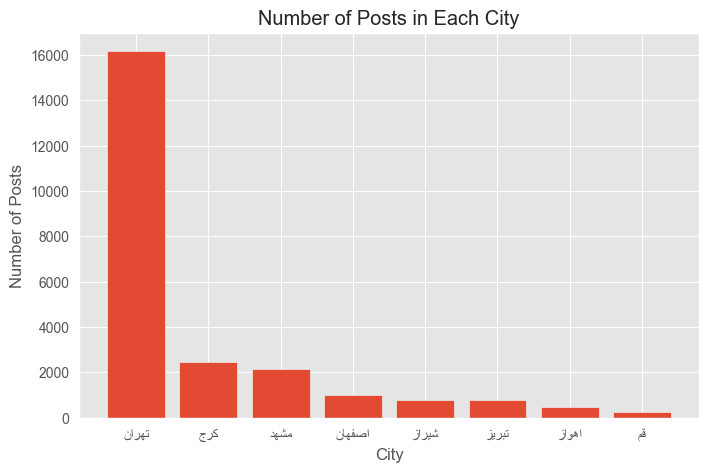

In [11]:
def to_fa(labels: list):
    return [get_display(reshape(label)) for label in labels]

vc = df["city_persian"].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(to_fa(vc.keys()), vc.values)
plt.title("Number of Posts in Each City")
plt.xlabel("City"); plt.ylabel("Number of Posts")
plt.show()

<blockquote>

Number of posts in Tehran is significanlty more than other cities. Additionally, the order of cities is exactly similar to the population of cities based on census of 1395 except for Karaj which is in the second place of posts but had 4th place in population. (This should be more investigated by Divar to see if Karaj posts are real or some may add Tehran posts in Karaj as well for getting more views.)

<img src="https://static2.eghtesadonline.com/serve/SBSfuBbfZTUh/b54EPYiYwLU,/%D8%AC%D9%85%D8%B9%DB%8C%D8%AA.jpg">

## Q2: Number of Posts Created by Business Types

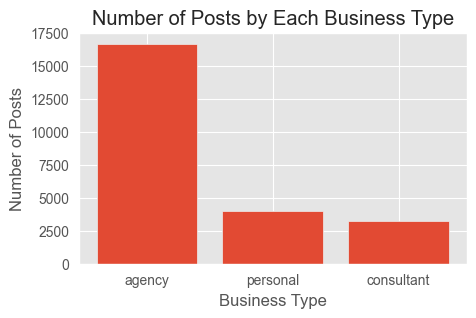

In [12]:
vc = df["business_type"].value_counts()
vc

plt.figure(figsize=(5, 3))
plt.bar(to_fa(vc.keys()), vc.values)
plt.title("Number of Posts by Each Business Type")
plt.xlabel("Business Type"); plt.ylabel("Number of Posts")
plt.show()

<blockquote>

Agencies post most of the posts on Divar real estate category. Personal posts are drastically less than agencies. (Consultants are similar to agencies)

However, the data of cities has been imbalanced and Tehran can change the distribution. Therefore, we plot this figure for each city below.

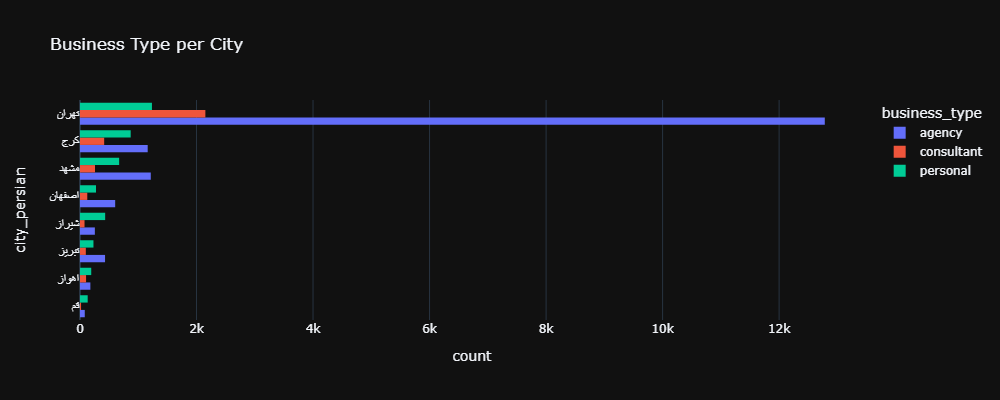

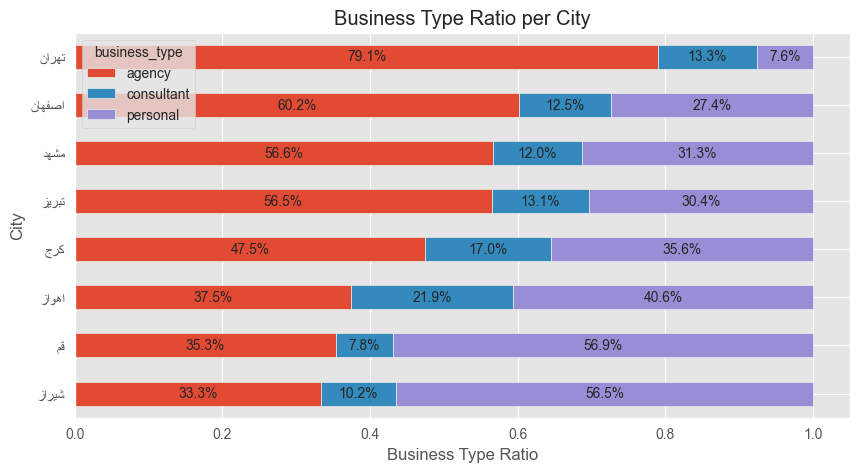

In [13]:
fig = px.histogram(df, y="city_persian", color='business_type', 
                   barmode='group', width=1000, height=400,
                   title="Business Type per City").update_yaxes(categoryorder='total ascending')
fig.show(renderer="png")

stack100 = (df.groupby(['city_persian','business_type']).size()/df.groupby(['city_persian']).size()).unstack().sort_values("agency")
stack100.index = to_fa(stack100.index)

stack100.plot(kind="barh", stacked=True, figsize=(10, 5))
for col in stack100:
    for i, (cs, ab, pc) in enumerate(zip(stack100.cumsum(axis=1)[col], stack100[col], stack100[col])):
        plt.text(cs - ab / 2, i, str(np.round(pc * 100, 1)) + '%', va = 'center', ha = 'center')
plt.title("Business Type Ratio per City")
plt.xlabel("Business Type Ratio"); plt.ylabel("City")
plt.show()

<blockquote>

Interestingly, Tehran is an exception in having the largest agency ratio. Only 7.6% of posts are made by individual persons. About 92.4% are agencies or consultants. On the other hand, Shiraz has the most ratio of personal, and least ratio of agencies. This shows that in Tehran there are more agencies active. Also, having an agency account might be expensive or have specific benefits that Tehran agencies have decided to announce that. For the personal posts, we do not know if they were really personal or maybe an agency created a personal account. But Divar should work on making agency accounts more appealing for those who work in other cities.

## Q3: Price Outliers

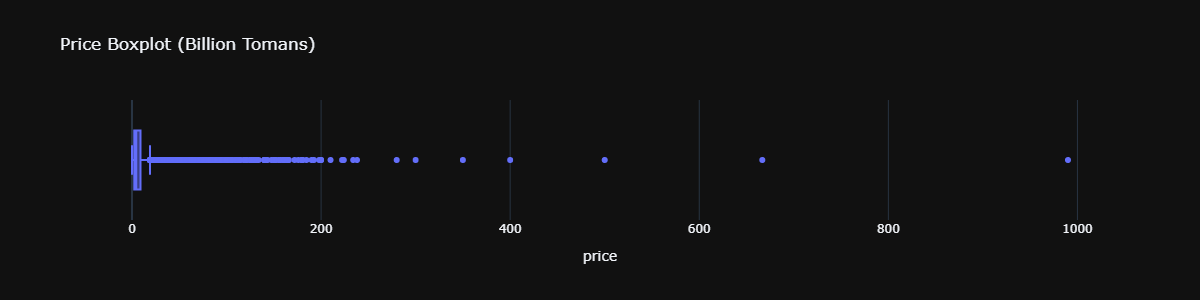

In [14]:
price_df = df.copy()
price_df["price"] = price_df['price_million'] / 1000
fig = px.box(price_df, x="price", width=1200, height=300, title="Price Boxplot (Billion Tomans)")
fig.show(renderer="png")

In [15]:
df[df["price_million"] > df["price_million"].quantile(0.999)].sample(5)  # There are some mistakes in these

token                                              title  promoted  \
19893  wYPWqwBI  ۱۰۰۰ متر ۶ مسترروم ویو ابدی بهشت نیاتوس مدرن آ...     False   
17209  wYHWBtJO               ۶۵۰ متر ویو ابدی بر فراز آسمان فرشته     False   
8038   wYiGMbfV    ۱۷۰۰ مستغلات/نیاوران گل سنک/تکواحدی کلید نخورده     False   
13885  wYQS14hj                      اپارتمان 161 متری فول امکانات      True   
17937  wYjq_Vah                  فروش یکجا ساختمان مسکونی در الهیه     False   

               price_persian  price_million   media  \
19893  ۳۵۰,۰۰۰,۰۰۰,۰۰۰ تومان  350000.000000  CAMERA   
17209  ۲۲۴,۰۰۰,۰۰۰,۰۰۰ تومان  224000.000000  CAMERA   
8038   ۲۳۸,۰۰۰,۰۰۰,۰۰۰ تومان  238000.000000  CAMERA   
13885  ۶۶۶,۶۶۶,۶۶۶,۶۶۹ تومان  666666.666669  CAMERA   
17937  ۵۰۰,۰۰۰,۰۰۰,۰۰۰ تومان  500000.000000     NaN   

             last_post_sort_date  inspection  image_count  has_chat  \
19893 2022-12-22 03:28:55.856353       False           18     False   
17209 2022-12-22 06:50:03.789661       False           15     False   
8038  2022-12-22 09:18:22.233122       False            5     False   
13885 2022-12-22 07:44:10.818544       False            8      True   
17937 2022-12-22 06:34:10.977654       False            0     False   

      district_persian city_persian business_type  
19893            الهیه        تهران        agency  
17209            الهیه        تهران        agency  
8038           نیاوران        تهران        agency  
13885    سازمان برنامه        تهران      personal  
17937            الهیه        تهران        agency

In [16]:
df[df["price_million"] < df["price_million"].quantile(0.0001)]  # These have no problem

token                                        title  promoted  \
4145   wYhqXNjk  ۱۵۰مترآپارتمان رزکان نو واریان شهر تک واحدی     False   
19946  wYZedbb7    امتیاز آپارتمان دو خوابه بدون واریزی صدرا     False   
20341  wYjK3lLQ                                  ۱۷۰مترتجاری     False   

          price_persian  price_million   media        last_post_sort_date  \
4145   ۳۵,۱۰۰,۰۰۰ تومان           35.1  CAMERA 2022-12-22 11:09:06.172732   
19946  ۲۰,۰۰۰,۰۰۰ تومان           20.0     NaN 2022-12-22 01:22:35.592323   
20341  ۴۰,۰۰۰,۰۰۰ تومان           40.0  CAMERA 2022-12-21 21:03:03.115193   

       inspection  image_count  has_chat district_persian city_persian  \
4145        False            1     False       شهرک بنفشه          کرج   
19946       False            0      True         شهر صدرا        شیراز   
20341       False            3      True        کوی مهدیس        اهواز   

      business_type  
4145         agency  
19946      personal  
20341      personal

<blockquote>

Some outliers like below have made a mistake and put the whole price in each meter price. Therefore, we have 4B Tomans for each meter and 161m of it would be 666B Tomans. (This happens a lot and Divar should fix it)

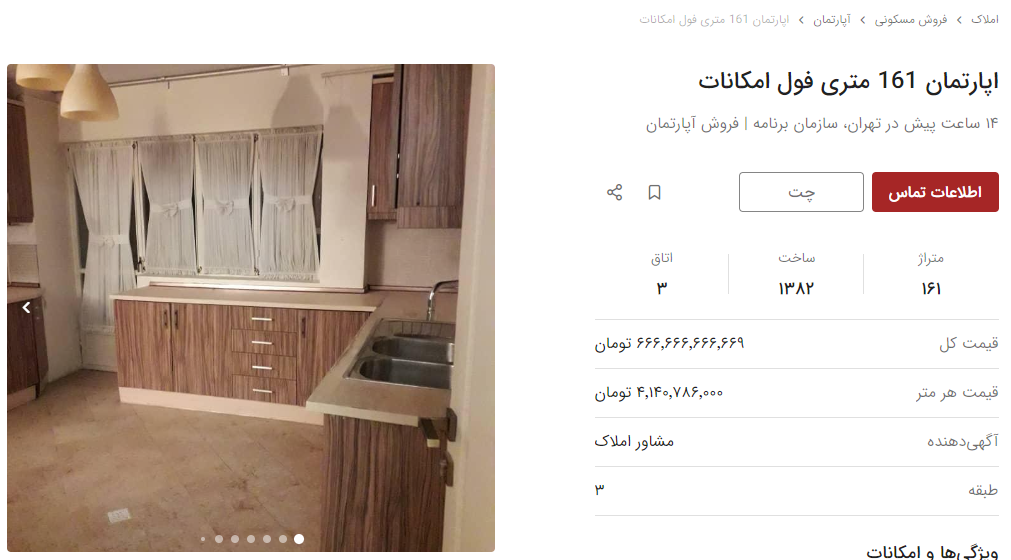

<blockquote>

Another one was selling 200 units at once as 2000m which would cost 990B Tomans.

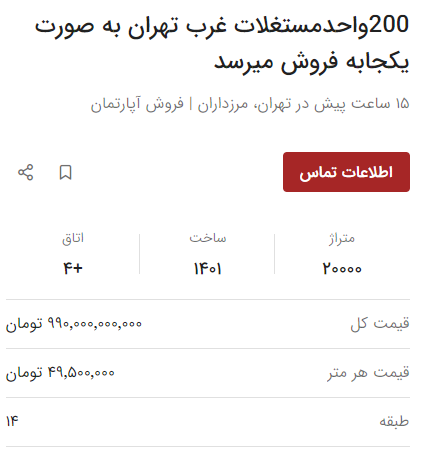

<blockquote>

And some are really luxurious.

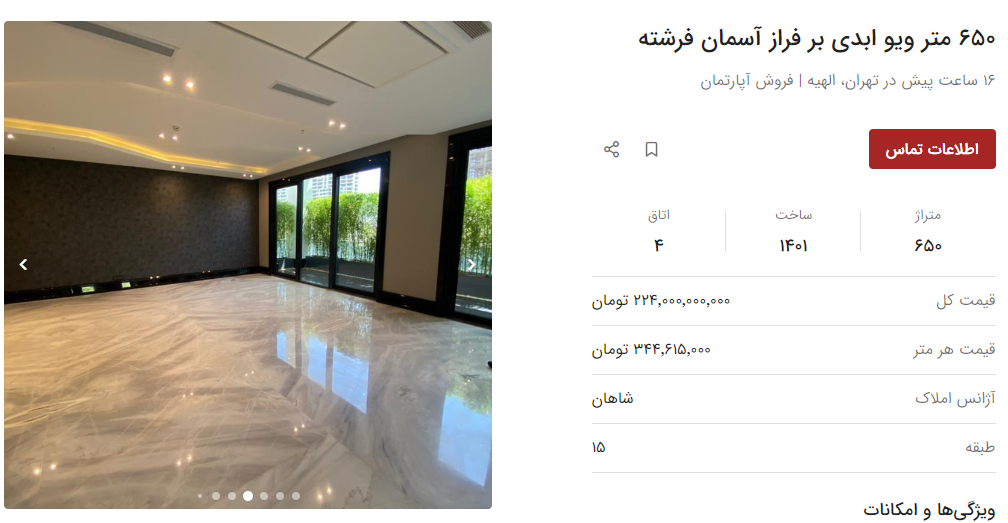

<blockquote>

For following analyses, we hide outliers to better visualize the data.

## Q4: Price in Cities

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_23336\4013583076.py:8: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



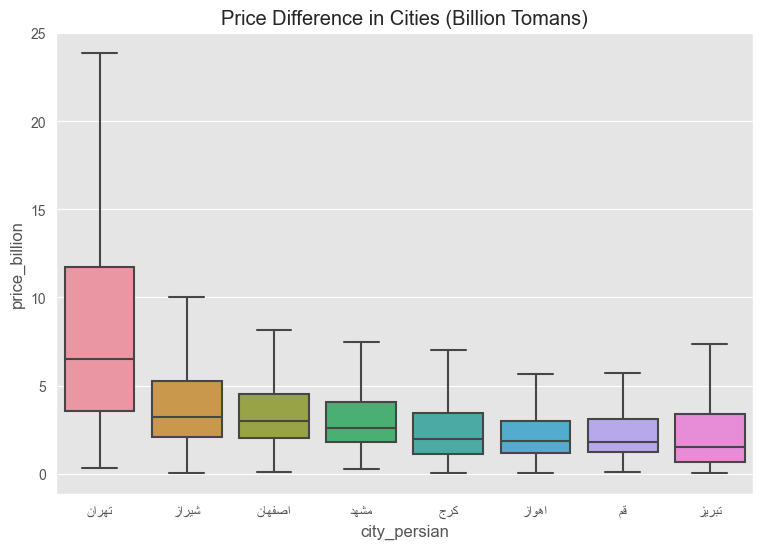

In [17]:
price_df = df.copy().sort_values("price_million", ascending=False)
price_df["price_billion"] = price_df['price_million'] / 1000
# fig = px.box(price_df, x="city_persian", y="price")
# fig.update_traces(boxpoints=False)
# fig.show(renderer="png")

plt.figure(figsize=(9, 6))
order = price_df.groupby(["city_persian"]).median()["price_million"].sort_values(ascending=False).index
ax = sns.boxplot(x="city_persian", y="price_billion", data=price_df, showfliers=False, order=order)
ax.set_xticklabels(to_fa([t.get_text() for t in ax.get_xticklabels()]))
plt.title("Price Difference in Cities (Billion Tomans)")
plt.show()

<blockquote>

Tehran has the highest prices in general, mostly ranging from 4B to 12B Tomans. It also has longer tail up to 24B Tomans. Next is Shiraz, but the prices in Shiraz are significanlty lower than Tehran. On the contrary, Tabriz seems to have the cheapest median while it's high whisker is higher than some other cities. It means generaly Tabriz has low prices, but there are also some expensive apartments there. Qom and Ahvaz upper whiskers are the lowest among all cities, showing that there aren't very expensive apartments in those cities. 

Also, it is worth mentioning that the box of Tehran is the largest among all, and Ahvaz has the smalles box, which means prices in Tehran are more diverse, while most prices in Ahvaz are close together.

## Q5: Number of Posts in Tehran Distircts

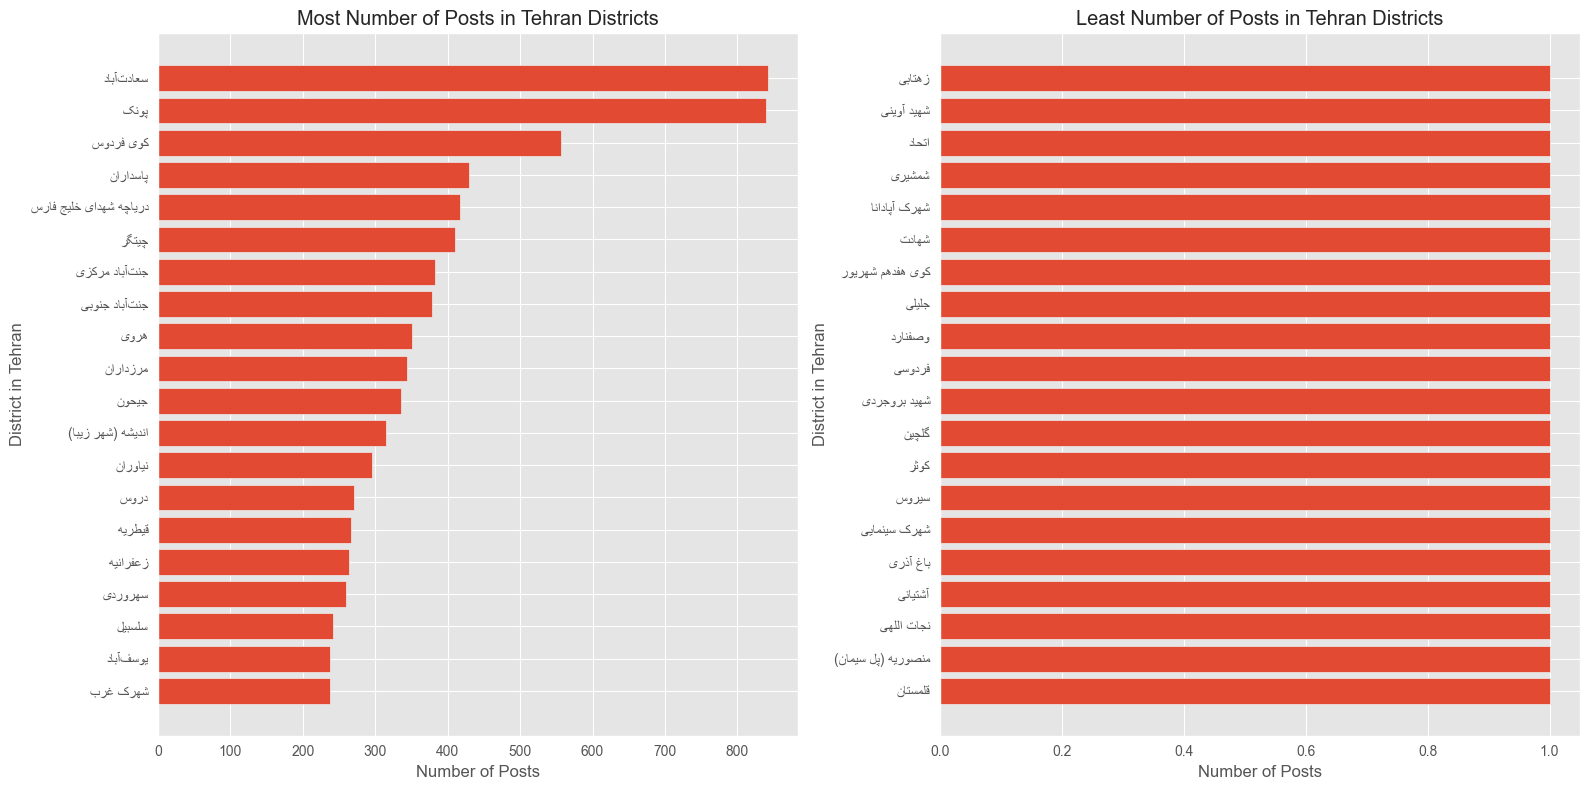

In [18]:
plt.figure(figsize=(16, 8))

vc = df[df["city_persian"] == "تهران"]["district_persian"].value_counts()[:20][::-1]
plt.subplot(1, 2, 1)
plt.barh(to_fa(vc.keys()), vc.values)
plt.title("Most Number of Posts in Tehran Districts")
plt.ylabel("District in Tehran"); plt.xlabel("Number of Posts")

vc = df[df["city_persian"] == "تهران"]["district_persian"].value_counts()[-20:][::-1]
plt.subplot(1, 2, 2)
plt.barh(to_fa(vc.keys()), vc.values)
plt.title("Least Number of Posts in Tehran Districts")
plt.ylabel("District in Tehran"); plt.xlabel("Number of Posts")

plt.tight_layout()
plt.show()

<blockquote>

Most posts are first in Sadat Abad and Punak at District 2. There are also many posts at west of Tehran such as Chitgar Lake and Jannat Abad. This shows that north and west of Tehran are most active in real estate.

Unfortunately, the shape files for Tehran Districts are not free and we cannot leverage geopandas to visualize our data on the map.

To better see this we use https://www.openstreetmap.org/ and https://overpass-turbo.eu/ to show the most number of posts in neighborhoods.

```
(
  rel(8321827);  // Sadat Abad
  rel(8321816);  // Punak
  rel(6728897);  // District 3
  rel(6728896);  // District 2
  rel(8321815);  // Jannat Abad
  rel(8321694);  // Marzdaran
  rel(8321739);  // Jeyhoon
  rel(4534491726);  // Chitgar
  rel(6729506);  // District 22
  rel(5656701493);  // Niavaran
  rel(8321846);  // Gheytarieh
  rel(8321856);  // Zaferanieh
  rel(8321681);  // Yousef Abad
);
out geom;
```

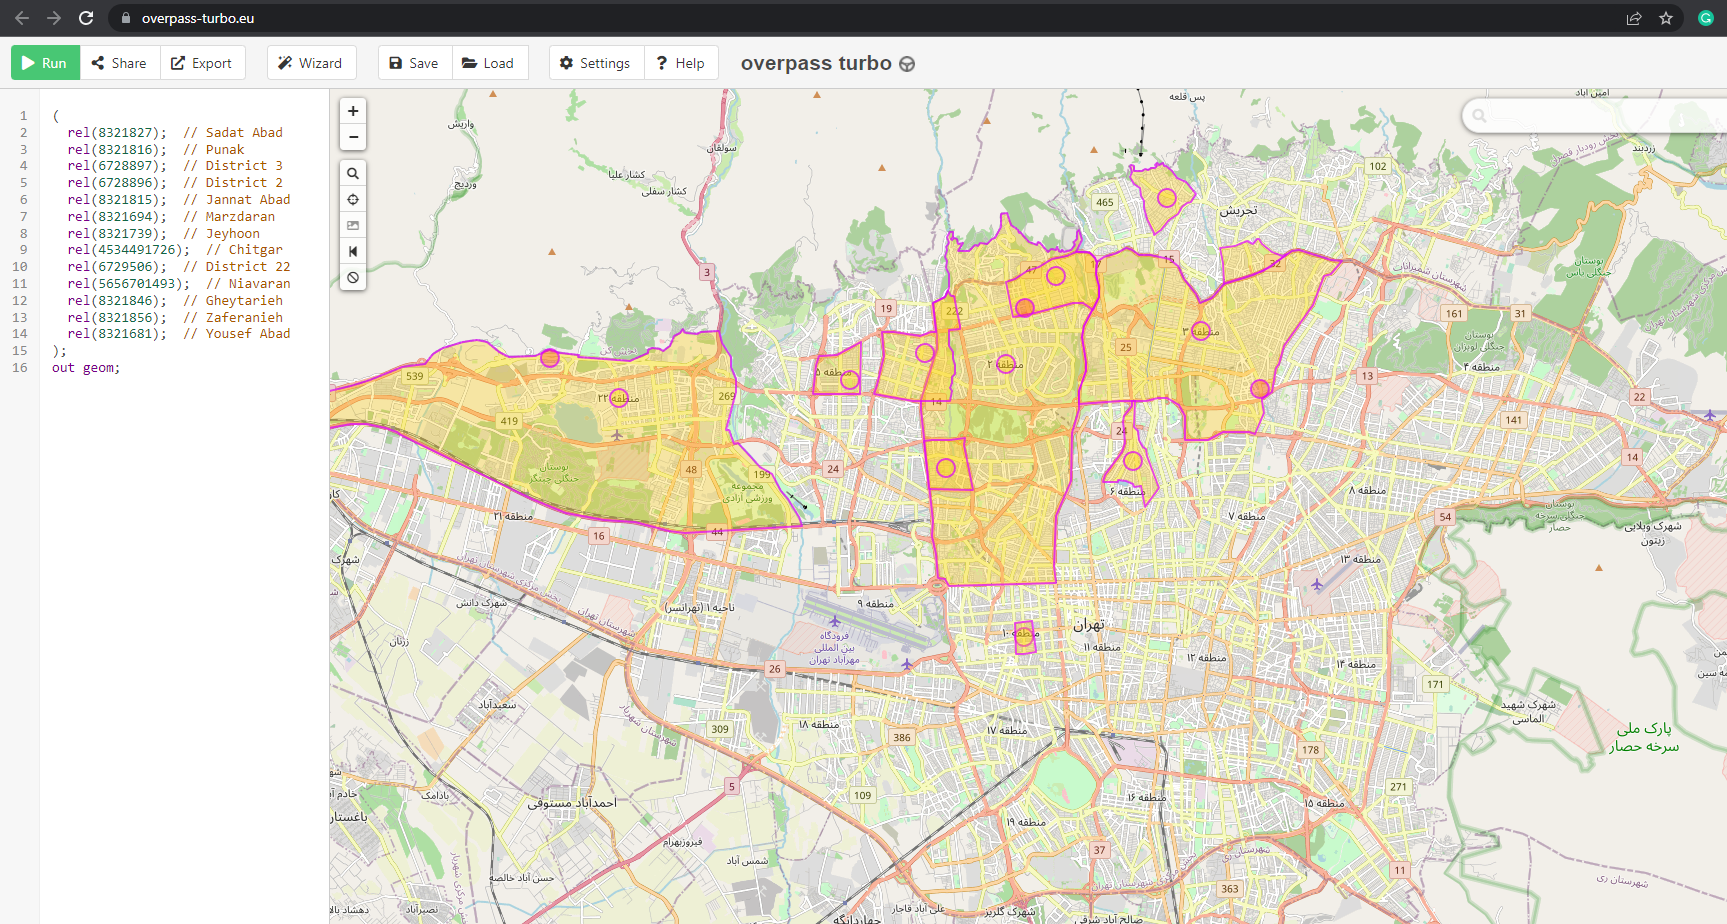

## Q6: Price in Districts of Tehran

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_23336\3764188865.py:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



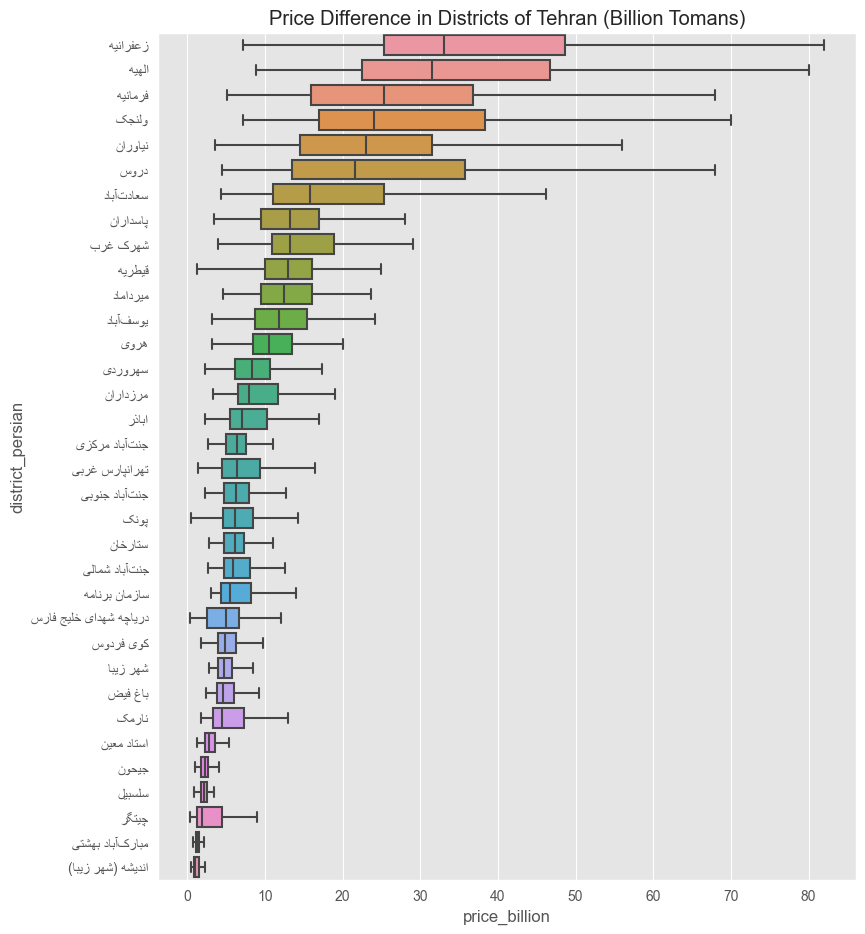

In [19]:
price_df = df[df["city_persian"] == "تهران"].copy().sort_values("price_million", ascending=False)
price_df["price_billion"] = price_df['price_million'] / 1000

# Filter Least frequent districts
vc = price_df["district_persian"].value_counts()
price_df = price_df[price_df["district_persian"].isin(vc[vc > 150].index)]

plt.figure(figsize=(9, 11))
order = price_df.groupby(["district_persian"]).median()["price_million"].sort_values(ascending=False).index
ax = sns.boxplot(y="district_persian", x="price_billion", data=price_df, showfliers=False, order=order)
ax.set_yticklabels(to_fa([t.get_text() for t in ax.get_yticklabels()]))
plt.title("Price Difference in Districts of Tehran (Billion Tomans)")
plt.show()

<blockquote>

To better visualize and also make it more accurate, we include only the districts which have more than 150 posts. In these districts we see that Zaferanieh, Elahie, Farmanie, Velenjak, ... have the highest overal prices. On the other hand, Andishe, Chitgar, and Salsabil had the least prices.
This plot best shows how expensive it is to buy a house in each of Tehran neighborhoods.


## Q7: Price per Business Type

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_23056\3118088884.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_23056\3118088884.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



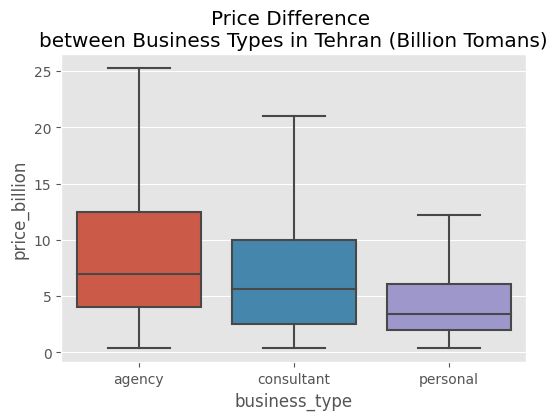

In [19]:
price_df = df[df["city_persian"] == "تهران"].copy().sort_values("price_million", ascending=False)
price_df["price_billion"] = price_df['price_million'] / 1000

order = price_df.groupby(["business_type"]).median()["price_million"].sort_values(ascending=False).index

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="business_type", y="price_billion", data=price_df, showfliers=False, order=order)
ax.set_yticklabels(to_fa([t.get_text() for t in ax.get_yticklabels()]))
plt.title("Price Difference \nbetween Business Types in Tehran (Billion Tomans)")
plt.show()

<blockqute>

First of all we limited this to Tehran because it had much different prices than other cities and also there were more agencies in Tehran which could make these results biased.

We see that agencies provide the highest prices, then consultants and then personal posters set the cheapest prices. The easy conclusion is that agencies put higher prices to keep room for bargaining, but personal accounts are more fair in pricing. Also we can conclude that agenices are actually fair and sell more expensive houses in general than persoanls. 

We need to further see the distribution of agencies in each district.

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_23056\3050369940.py:8: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



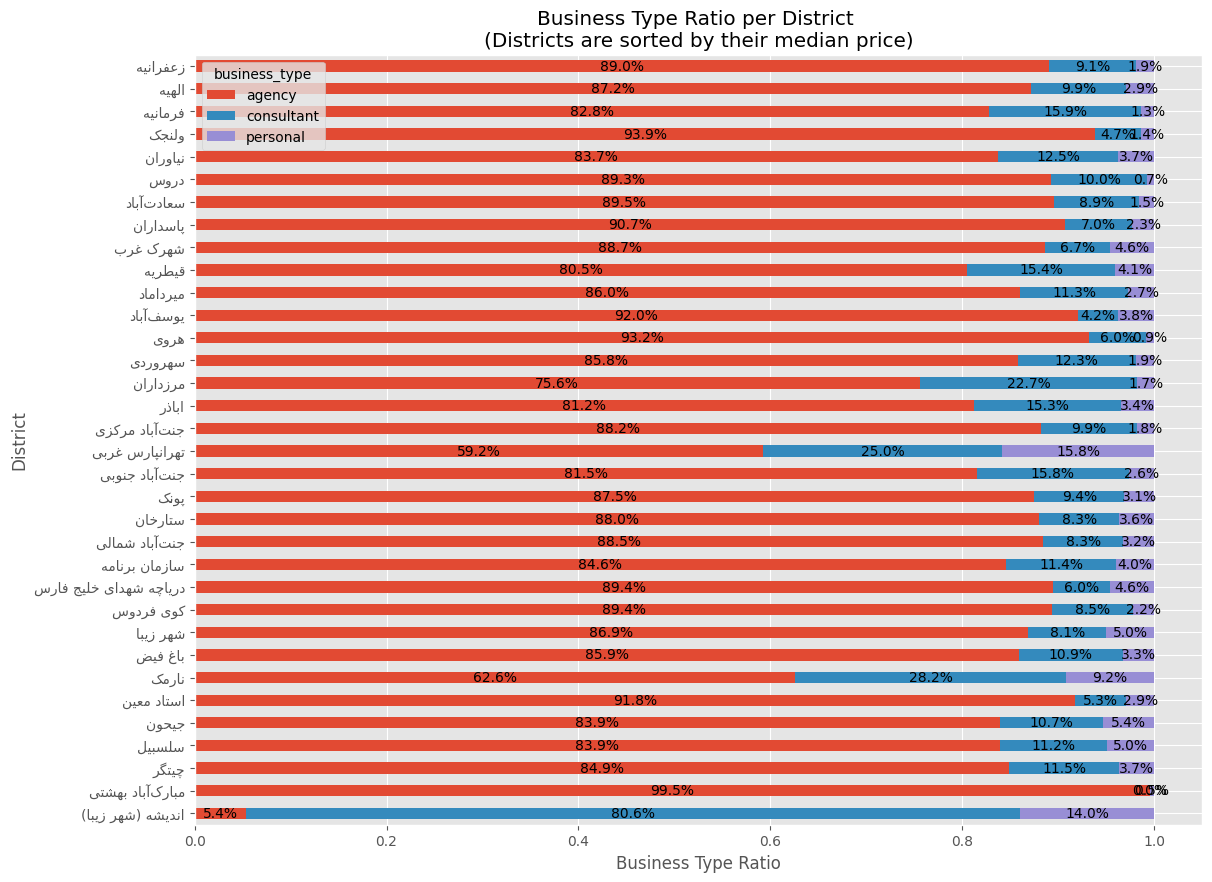

In [20]:
price_df = df[df["city_persian"] == "تهران"].copy().sort_values("price_million", ascending=False)
price_df["price_billion"] = price_df['price_million'] / 1000

# Filter Least frequent districts
vc = price_df["district_persian"].value_counts()
price_df = price_df[price_df["district_persian"].isin(vc[vc > 150].index)]

order = price_df.groupby(["district_persian"]).median()["price_million"].sort_values(ascending=True).index

stack100 = (price_df.groupby(['district_persian','business_type']).size()/price_df.groupby(['district_persian']).size()).unstack().sort_values("agency")
stack100 = stack100.reindex(order)
stack100.index = to_fa(stack100.index)
stack100 = stack100.fillna(0)

stack100.plot(kind="barh", stacked=True, figsize=(13, 10))
for col in stack100:
    for i, (cs, ab, pc) in enumerate(zip(stack100.cumsum(axis=1)[col], stack100[col], stack100[col])):
        plt.text(cs - ab / 2, i, str(np.round(pc * 100, 1)) + '%', va = 'center', ha = 'center')
plt.title("Business Type Ratio per District \n(Districts are sorted by their median price)")
plt.xlabel("Business Type Ratio"); plt.ylabel("District")
plt.show()

<blockquote>

Top rows are the most expensive districts. We see that personal posts are slightly more available in cheaper districts. This might be due to the fact that real estate agencies would have a higher revenue from more expensive apartments and choose to operate in expensive neighborhoods slightly more.

## Q8: Chat Enabled

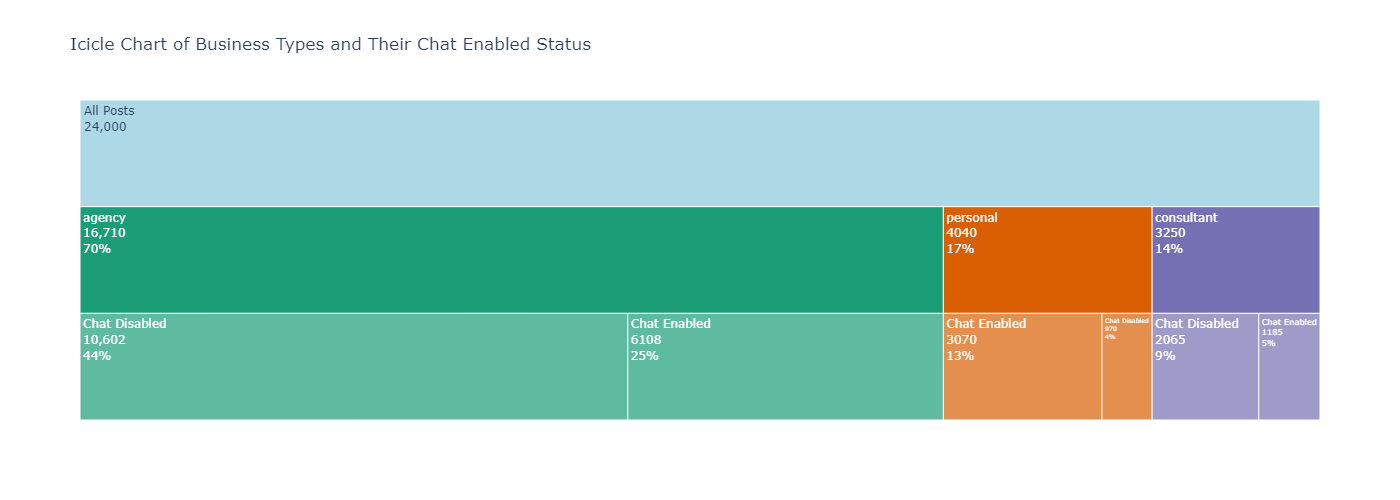

In [21]:
dfc = df.copy()
dfc["has_chat_"] = "Chat Disabled"
dfc.loc[dfc["has_chat"] == True, "has_chat_"] = "Chat Enabled"

fig = px.icicle(
    dfc, 
    path=[px.Constant(f"All Posts"), "business_type", "has_chat_"],
    color_discrete_sequence=px.colors.qualitative.Dark2,
    width=1400, height=500,
    title = "Icicle Chart of Business Types and Their Chat Enabled Status"
)
fig.update_traces(
    root_color="lightblue", 
    tiling = dict(orientation='v'),
    textinfo="percent entry+label+value+text", 
#     marker = {"colors": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]},
)
fig.show(renderer="png")

<blockquote>

Another interesting result we find is that Agencies tend to disable the text chat ability in Divar (38% enabled), whereas Perosnal accounts mostly make their chats enabled (76% enabled). This can be attributed to the fact that agencies want to talk directly to the customer because it is faster to convey more information, and also they can introduce and sell more cases over phone. However, personal accounts might get disturbed by calls and prefer to text whenever they have the time so they enable their text chats.

## Q9: Promotions

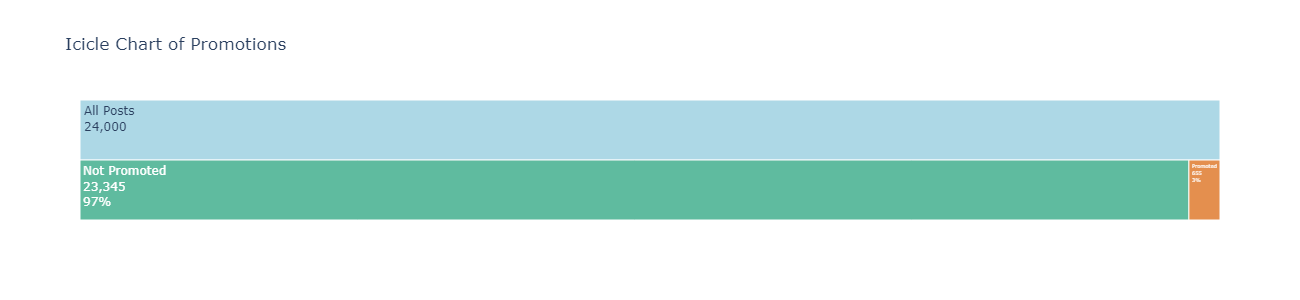

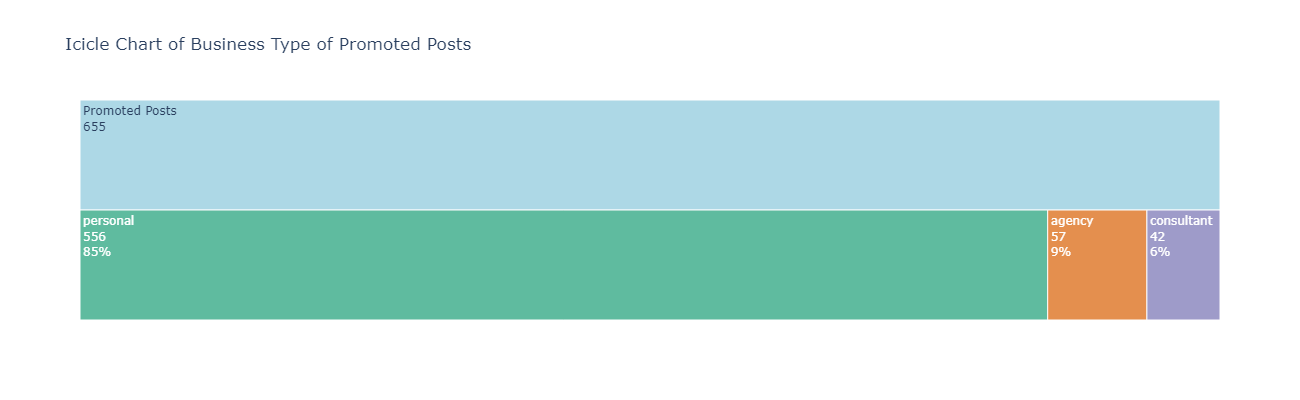

In [22]:
dfc = df.copy()
dfc["promoted_"] = "Not Promoted"
dfc.loc[dfc["promoted"] == True, "promoted_"] = "Promoted"

# fig = px.sunburst(dfc, path=["promoted_"], title='Number of Promoted Posts')   # "parties", "has_words", "response"
# fig.update_traces(textinfo="percent entry+label+value+text", )
# fig.show(renderer="png")

fig = px.icicle(
    dfc, 
    path=[px.Constant(f"All Posts"), "promoted_"],
    color_discrete_sequence=px.colors.qualitative.Dark2,
    width=1300, height=300,
    title = "Icicle Chart of Promotions"
)
fig.update_traces(
    root_color="lightblue", 
    tiling = dict(orientation='v'),
    textinfo="percent entry+label+value+text", 
    # marker = {"colors": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]},
)
fig.show(renderer="png")

dfc = dfc[dfc["promoted"] == True]
fig = px.icicle(
    dfc, 
    path=[px.Constant(f"Promoted Posts"), "business_type"],
    color_discrete_sequence=px.colors.qualitative.Dark2,
    width=1300, height=400,
    title = "Icicle Chart of Business Type of Promoted Posts"
)
fig.update_traces(
    root_color="lightblue", 
    tiling = dict(orientation='v'),
    textinfo="percent entry+label+value+text", 
    # marker = {"colors": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]},
)
fig.show(renderer="png")

<blockquote>

First of all we see that only 3% of the posts were paid to be promoted (فوری).
Second, we see that personal accounts had promoted their posts much more than agencies and consultants (85% vs. 15%). 

In Q2 we observed that most of the posts are made by agencies and only a few are by personal accounts. Based on Q2 this promotion pattern shows more significant information. Personal accounts pay significantly more than agencies. It shows that first, Divar is getting paid by the small amount of personal users it has rather than those many agencies (However agencies probably pay additional fee too, but they dont pay for promotions). Moreover, agencies pobably have found other ways to put their posts in top of the list like posting one apartment multiple times with slightly different information that they do not need to use the paid options of Divar for making the post more seen.

## Q10: Media

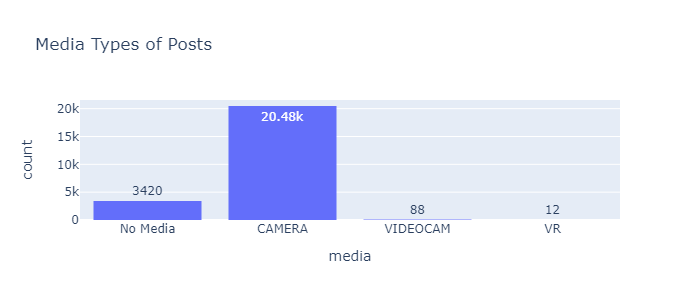

In [23]:
dfc = df.copy()
dfc = dfc.fillna("No Media")

fig = px.histogram(dfc, x="media", height=300, title="Media Types of Posts", text_auto=True)
fig.show(renderer="png")

<blockquote>

The most used version of media on posts is image (camera). Then many do not have any media, and after that just a few add videos or VR of the apartment.

## Q11: Correlations

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_23056\2623753099.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



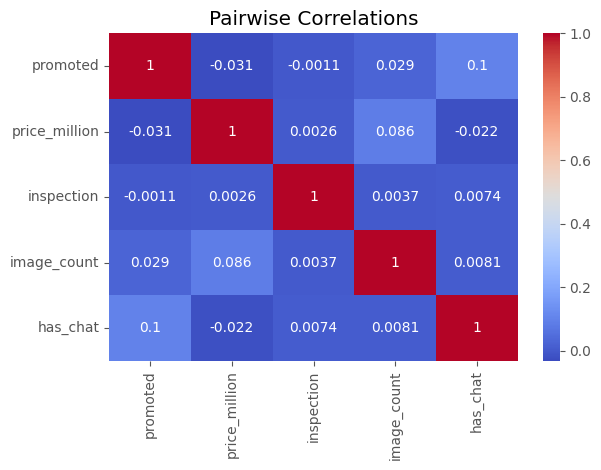

In [24]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap='coolwarm')
plt.title("Pairwise Correlations")
plt.tight_layout()
plt.show()

<blockquote>

There are no significant correalations between numeric features. Intuitively, for predicting price, we need city+district and how big the house is. In this correlation we do not have the districts (We analysed their effect in Q4 & Q5), and we do not have the meters of the houses because it was not available in the listing. (And we could not request 24000 posts to get all the features).

Nonetheless, I look forward to training models and see if they can predict the features of this dataset with what is available or not and which cities might be eaiser to predict.

Based on this correlation map, the largest one is 0.1 between promoted and has_chat, which actually might be due to business type, becuase we observed that personal accounts enable their chats and also buy most of the promotions, so that might have played a role here to make a slightly positive correlation.

# Summary



* **Data Scraping:** <br>
In this section we found Divar's API and requested the pages and saved the UI data.
* **Data Cleaning:** <br>
In this phase, we dropped unused columns and extracted clean data out of UI strings, and fixed data types.
* **EDA:** <br>
In EDA, we had a comprehensive analysis of the features we had and answered 11 questions based on the data. Some of the interesting points were:
  * The number of posts matches nicely with the population of cities.
  * There are some mistakes in pricing by users which can be prevented by Divar.
  * Tehran has the most number of posts and most expensive apartments, which are more concentrated at north and west of this city.
  * We provided an up to date estimate of prices in each neighborhood.
  * Agencies tend to announce higher prices than personal accounts (Or work in more expensive cases).
  * Personal accounts enable their chats and have the highest share in buying promotions for their posts.
  * Most favoured media for posts is image and least frequent is VR.





